# Baselines implementation

Let's implement the baselines iot obtain the first downscaling results

In [35]:
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import xarray as xr
import xarray.plot as xplt
import cartopy.crs as ccrs
#import xesmf as xe
#import dataset
#from cdo import Cdo

path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/utils"
os.chdir(path)

In [38]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/data"
os.chdir(path)

week_2km = xr.open_dataset("random_week_2km.nc")
week_12km = xr.open_dataset("random_week_12km.nc")
week_2km

<xarray.Dataset>
Dimensions:     (rlat: 1542, rlon: 1542, time: 168)
Coordinates:
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
    lon         (rlat, rlon) float32 ...
    lat         (rlat, rlon) float32 ...
    height_2m   float32 ...
    height_10m  float32 ...
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-28T23:00:00
Data variables:
    T_2M        (time, rlat, rlon) float32 ...
    RELHUM_2M   (time, rlat, rlon) float32 ...
    TOT_PR      (time, rlat, rlon) float32 ...

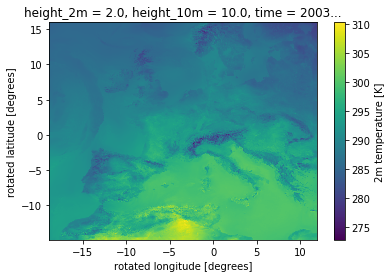

In [24]:
week_2km.T_2M.isel(time=-1).plot()

The first method is the bilinear implementation. I didn't managed to find a fast way to do so, but CDO can do it easily with remapbil.

In [25]:
#downs_week_grid = xr.Dataset({"lat": week_2km["lat"].values, "lon": week_2km["lon"].values})
#downs_week = xe.Regridder(week_12km, downs_week_grid, "bilinear")

In [26]:
mean_lon = week_2km["lon"].mean(dim = "rlat")

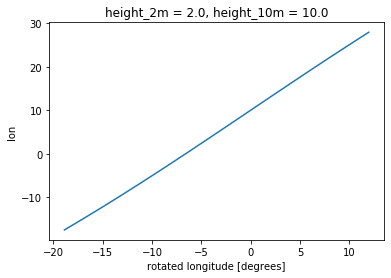

In [27]:
mean_lon.plot()

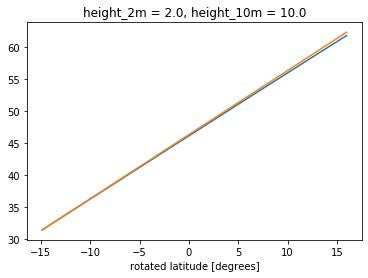

In [28]:
mean_lat = week_2km["lat"].mean(dim = "rlon")
mean_lat.plot()
(week_2km["rlat"] + mean_lat[0]-week_2km["rlat"][0]).plot()

## Different interpolations

### Bilinear interpolation

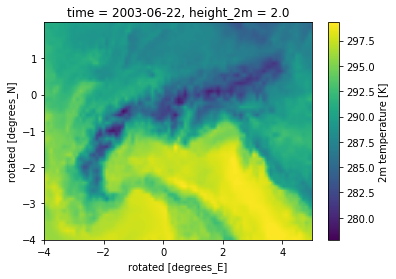

In [39]:
lin_downs = xr.open_dataset("lin_downs.nc")
LIN_T = lin_downs.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time=0)
LIN_T.plot()

### Bicubic interpolation

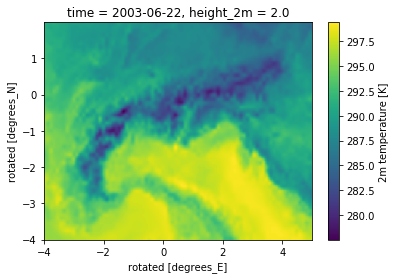

In [43]:
cubic_downs = xr.open_dataset("cub_downs.nc")
CUB_T = cubic_downs.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).T_2M.isel(time=0)
CUB_T.plot()

Let's first try to get the lat/lon values from rlat/rlon. The first step is finding the relation between those two coordinates in the 2km res, to apply it to the 12km one.

The bilinear, bicubic and quintic interpolation will be made using interp2d, with x and y calculated from lon and lat values

In [10]:
#grid_x, grid_y = np.mgrid[-18.82:11.87:281j, -14.85:15.95:280j]
#fgrid_x, fgrid_y = np.mgrid[-18.86:11.98:1542j, -14.86:15.98:1542j]
#interp2d
#grid_x
#griddata((grid_x, grid_y), week_12km.T_2M.isel(time=1), (fgrid_x, fgrid_y), method='linear')

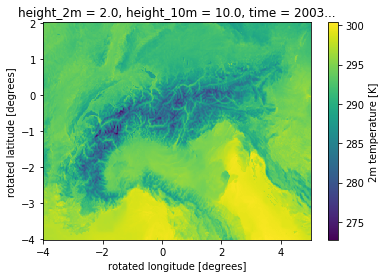

In [11]:
lat_bnd = [-4, 2]
lon_bnd = [-4, 5]
HR_T = week_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time=-1)
LR_T = week_12km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time=-1)
T = [HR_T,LR_T]
T[0].plot()

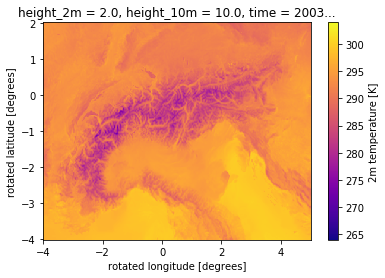

In [12]:
#week_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time=-1).plot(vmin = 264, vmax = 304, cmap='plasma')
HR_T.plot(vmin = 264, vmax = 304, cmap='plasma')

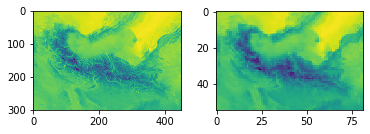

In [13]:
fig = plt.figure()
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(T[i])
plt.show()

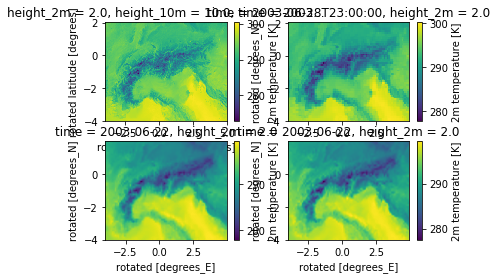

In [46]:
fig, axes = plt.subplots(ncols=2, nrows=2)
HR_T.plot(ax=axes[0, 0])
LR_T.plot(ax=axes[0, 1])
xplt.plot(LIN_T, ax=axes[1, 0])
xplt.plot(CUB_T, ax=axes[1, 1])
plt.draw()